In [ ]:
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torchvision.transforms.functional as  TF
import medmnist
from medmnist import INFO
import pytorch_lightning as pl
import PIL
import torch
import random
import numpy as np
import os
import matplotlib.pyplot as plt
import torchvision
from datasets.CnMedMNIST2D_dataset import CnMedMNISTDataModule
from datasets.Z2MedMNIST2D_dataset import Z2MedMNISTDataModule
from datasets.D4MedMNIST2D_dataset import D4MedMNISTDataModule
from datasets.DDMNIST_dataset import DDMNIST
from datasets.C4xC4DDMNIST_dataset import D4DDMNISTDataModule
from utils.initialise_W_utils import initialise_W_real_Cn_irreps
from models.FunctorModel import FunctorModel
import torch.nn.functional as F

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

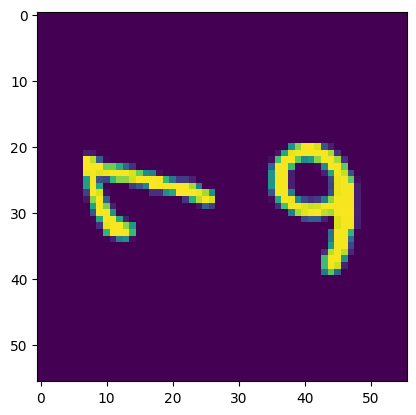

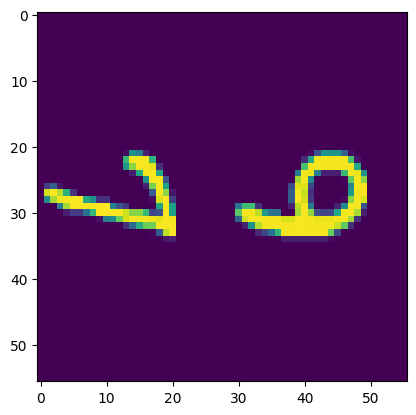

tensor(11)
tensor([2, 3])


In [9]:
def index_to_pair(idx: torch.LongTensor) -> torch.LongTensor:
    """
    Given idx of shape (...) with values in 0..15,
    returns a tensor of shape (..., 2) where each entry [k,0]=i and [k,1]=j
    such that idx = 4*i + j.

    Works equally on scalars, 1D or higher-dimensional LongTensors.
    """
    # ensure long dtype
    idx = idx.to(dtype=torch.long)
    i = torch.div(idx, 4, rounding_mode='floor')  # integer division by 4
    j = idx % 4                                   # remainder mod 4
    return torch.stack((i, j), dim=-1)

data_module = D4DDMNISTDataModule(1)
data_module.setup()
train_loader = data_module.train_dataloader()
val_loader = data_module.val_dataloader()
test_loader = data_module.test_dataloader()
for i, ((x1, y1), (x2, y2), transformation_type, covariate) in enumerate(train_loader):
    imshow(x1[0])
    imshow(x2[0])
    break

print(covariate[0])
print(index_to_pair(covariate[0]))

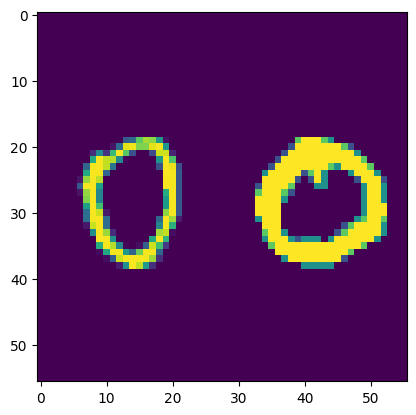

tensor([[[-0.1177, -0.1177, -0.1177,  ..., -0.1177, -0.1177, -0.1177],
         [-0.1177, -0.1177, -0.1177,  ..., -0.1177, -0.1177, -0.1177],
         [-0.1177, -0.1177, -0.1177,  ..., -0.1177, -0.1177, -0.1177],
         ...,
         [-0.1177, -0.1177, -0.1177,  ..., -0.1177, -0.1177, -0.1177],
         [-0.1177, -0.1177, -0.1177,  ..., -0.1177, -0.1177, -0.1177],
         [-0.1177, -0.1177, -0.1177,  ..., -0.1177, -0.1177, -0.1177]]])
torch.Size([1, 56, 56])


In [6]:
data = DDMNIST(train=False, images_per_class=50)
img1, img2, y = data.__getitem__(0)
combined = data._combine_images(img1[0], img2[0])
imshow(combined)
print(combined)
print(combined.shape)

In [10]:
data.labels

tensor([ 0,  0,  0,  ..., 99, 99, 99])

Z2 action: flip
Z2 action: flip
Z2 action: flip


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.78039217..0.94509804].


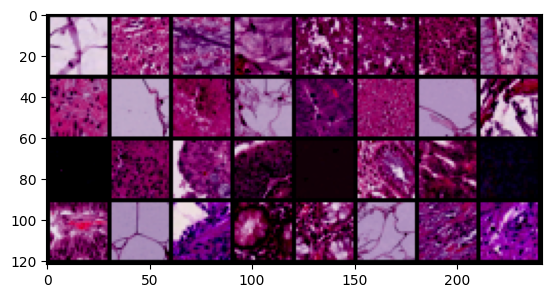

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.78039217..0.94509804].


tensor([[0],
        [5],
        [4],
        [4],
        [2],
        [2],
        [2],
        [6],
        [5],
        [0],
        [2],
        [0],
        [8],
        [2],
        [0],
        [4],
        [1],
        [2],
        [8],
        [8],
        [1],
        [6],
        [8],
        [1],
        [8],
        [0],
        [5],
        [6],
        [6],
        [0],
        [7],
        [5]])


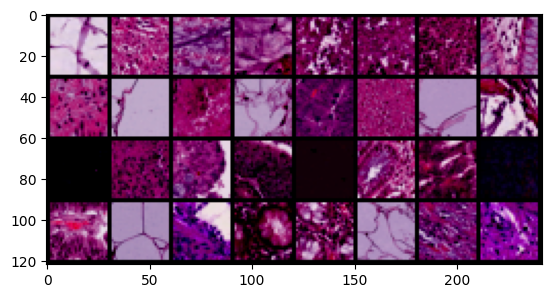

In [3]:
data_module = Z2MedMNISTDataModule('pathmnist', batch_size=32, resize=False, as_rgb=True, size=28, download=True)
data_module.setup()
train_loader = data_module.train_dataloader()
val_loader = data_module.val_dataloader()
test_loader = data_module.test_dataloader()

latents = []
for i, ((x1, y1), (x2, y2), transformation_type, covariate) in enumerate(train_loader):
    imshow(torchvision.utils.make_grid(x1))
    print(y1)
    imshow(torchvision.utils.make_grid(x2))
    break



In [3]:
import torch
W = torch.eye(512).flip(dims=[1])
eigs, _ = torch.linalg.eig(W)
n_ones = torch.sum(torch.abs(eigs - 1) < 1e-2).item()
n_neg_ones = torch.sum(torch.abs(eigs + 1) < 1e-2).item()
print(f"Number of eigenvalues close to 1: {n_ones}")
print(f"Number of eigenvalues close to -1: {n_neg_ones}")

Number of eigenvalues close to 1: 256
Number of eigenvalues close to -1: 256


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8039216..0.92156863].


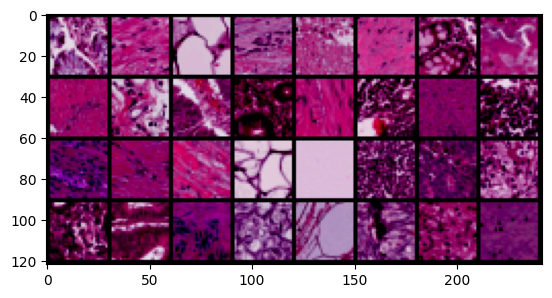

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8039216..0.92156863].


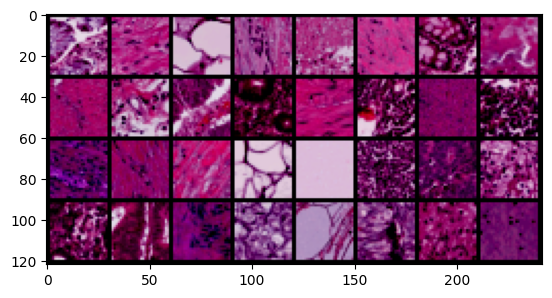

In [7]:
data_module = D4MedMNISTDataModule('pathmnist', batch_size=32, resize=False, as_rgb=True, size=28, download=True)
data_module.setup()
train_loader = data_module.train_dataloader()
val_loader = data_module.val_dataloader()
test_loader = data_module.test_dataloader()

latents = []
for i, ((x1, y1), (x2, y2), transformation_type, covariate) in enumerate(train_loader):
    imshow(torchvision.utils.make_grid(x1))
    imshow(torchvision.utils.make_grid(x2))
    break



In [29]:
import torchvision.transforms.functional as  TF

def augment_image(img: torch.Tensor):
    choice = random.randint(0, 7)
    choice = 7

    if choice == 0:  # Identity
        res = img
    elif choice == 1:  # r
        res = TF.rotate(img, 90)
    elif choice == 2:  # rr
        res = TF.rotate(img, 180)
    elif choice == 3:  # rrr
        res = TF.rotate(img, 270)
    elif choice == 4:  # srr
        res = TF.hflip(img)
    elif choice == 5:  # s
        res = TF.vflip(img)
    elif choice == 6:  # srrr
        res = TF.rotate(TF.hflip(img), 90)
    elif choice == 7:  #sr
        res = TF.rotate(TF.vflip(img), 90)

    return res, choice

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99215686..0.7019608].


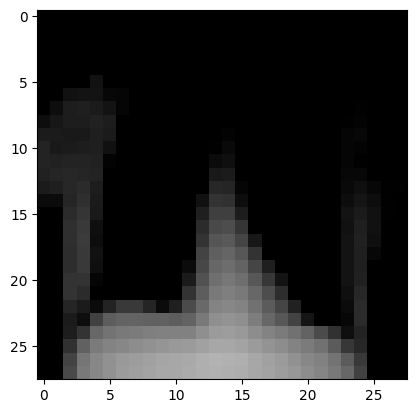

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99215686..0.7019608].


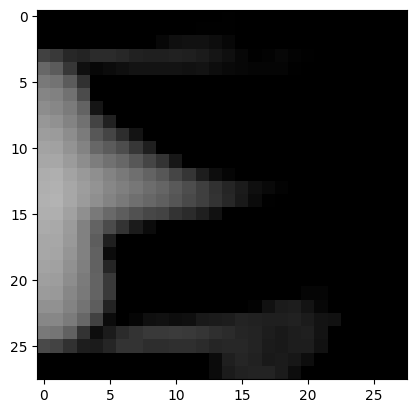

In [30]:
imshow(x1[0,...])
x2, _ = augment_image(x1[0,...])
imshow(x2)

In [102]:
W = model.get_W()
eigs, _ = torch.linalg.eig(W)

In [103]:

latent1 = latents[0]
transformed_latent = model.get_transformed_latent_from_generator(latent1, torch.tensor(0, device='cuda:0'), torch.ones(32, dtype=torch.int, device='cuda:0'))
transformed_latent_2 = F.linear(latent1, W)
print(f"Sanity check passed: {torch.allclose(transformed_latent, transformed_latent_2)}")

Sanity check passed: True


In [104]:
latent2 = latents[1]
print(f"MSE(WEx1, Ex2): {F.mse_loss(transformed_latent, latent2).item()}")
print(f"MSE(W^2Ex1, Ex2): {F.mse_loss(F.linear(latent1, W@W), latent1).item()}")

MSE(WEx1, Ex2): 0.0600561648607254
MSE(W^2Ex1, Ex2): 0.17510081827640533


In [1]:
import medmnist
INFO = medmnist.INFO
# Get all datasets
datasets = [dataset for dataset in list(INFO.keys()) if '3d' not in dataset]
base_commands = []
for dataset in datasets:
    base_commands.append(
            f'python3 lightning_train_and_eval.py --run=functor \
                --lambda_t=0.5 --lambda_W=0.5 --data_flag={dataset} --dataset=z2 --W_init=orthogonal')
    
    base_commands.append(
            f'python3 lightning_train_and_eval.py --run=fixed_identity \
                --lambda_t=0.5 --lambda_W=0. --data_flag={dataset} --dataset=z2 --W_init=identity --fix_rep')

    base_commands.append(
            f'python3 lightning_train_and_eval.py --run=fixed_regular \
                --lambda_t=0.5 --lambda_W=0. --data_flag={dataset} --dataset=z2 --W_init=regular --fix_rep')

    base_commands.append(
        f'python3 lightning_train_and_eval.py --run=block_diagonal \
                --lambda_t=0.5 --lambda_W=0.5 --data_flag={dataset} --dataset=z2 --W_init=block_diagonal --block_size=32')

commands = base_commands * 10
print(len(commands))

480


In [105]:
print(F.mse_loss(W@W, torch.eye(512, device='cuda:0')).item())
print(torch.dist(W@W, torch.eye(512, device='cuda:0')).item())

0.009891806170344353
50.922271728515625


In [106]:
#Count how many eigs are 1
print(f"number of eigs ==  1: {torch.sum(torch.isclose(eigs, torch.tensor(1,dtype=torch.complex64), rtol=1e-2)).item()}")
print(f"number of eigs == -1: {torch.sum(torch.isclose(eigs, torch.tensor(-1,dtype=torch.complex64), rtol=1e-2)).item()}")
print(f"number of eigs ==  0: {torch.sum(torch.isclose(eigs, torch.tensor(0,dtype=torch.complex64), rtol=1e-2)).item()}")

number of eigs ==  1: 0
number of eigs == -1: 0
number of eigs ==  0: 0


In [112]:
W_inverse = torch.linalg.solve(W, torch.eye(512, device='cuda:0'))
print(torch.dist(W, W_inverse).item())

49.121734619140625


Using x2 angle = 90


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9607843..1.0].


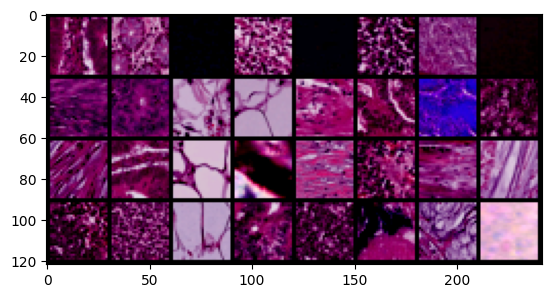

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9607843..1.0].


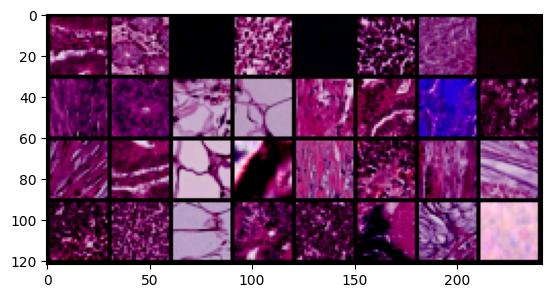

In [10]:
data_module = CnMedMNISTDataModule('pathmnist', batch_size=32, resize=False, as_rgb=True, size=28, download=True, x2_angle=90)
data_module.setup()
train_loader = data_module.train_dataloader()
val_loader = data_module.val_dataloader()
test_loader = data_module.test_dataloader()


for i, ((x1, y1), (x2, y2), transformation_type, covariate) in enumerate(train_loader):
    break

imshow(torchvision.utils.make_grid(x1))
imshow(torchvision.utils.make_grid(x2))

In [6]:
from datasets.MedMNIST2D_dataset import MedMNISTDataModule
data_module = MedMNISTDataModule('pathmnist', batch_size=32, resize=False, as_rgb=True, size=28, download=True)
data_module.setup()
train_loader = data_module.train_dataloader()
val_loader = data_module.val_dataloader()
test_loader = data_module.test_dataloader()

for i, (x, y) in enumerate(val_loader):
    break

#imshow(torchvision.utils.make_grid(x))
print(x.shape)
print(y.shape)
print(y)

torch.Size([32, 3, 28, 28])
torch.Size([32, 1])
tensor([[5],
        [0],
        [1],
        [7],
        [1],
        [4],
        [3],
        [8],
        [6],
        [7],
        [3],
        [7],
        [2],
        [2],
        [5],
        [5],
        [7],
        [5],
        [4],
        [8],
        [6],
        [4],
        [4],
        [3],
        [5],
        [6],
        [6],
        [6],
        [0],
        [3],
        [0],
        [2]])


In [34]:
size=28
download=False
as_rgb=True
info = INFO['tissuemnist']
DataClass = getattr(medmnist, info['python_class'])
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=[.5], std=[.5])
            ])
train_dataset = DataClass(split='train', transform=transform, download=download, as_rgb=as_rgb, size=size)
from datasets.CnMedMNIST2D_dataset import PairedCnMedMNIST2D
paired_train_dataset = PairedCnMedMNIST2D(train_dataset, transform, x2_angle=90, split='train')
#dl = DataLoader(train_dataset, batch_size=32, shuffle=True)
dl = DataLoader(paired_train_dataset, batch_size=32, shuffle=True)


# for i, (x, y) in enumerate(dl):
#     break
for i, (x1,y1), (x2,y2) in enumerate(dl):
    break

print(x.shape)

ValueError: not enough values to unpack (expected 3, got 2)

In [32]:
from models.FunctorModel import FunctorModel

model_path = '/home/rma55/git-repos/MedMNIST_functorial/tb_logs/pathmnist/functor/test_t_reduction_sum_resnet18_lambdaT_0.001_lambdaW_0.0/version_0/checkpoints/best_model.ckpt'
model = FunctorModel.load_from_checkpoint(model_path).cpu()
model.eval()
W4 = torch.linalg.matrix_power(model.W, 4)
print(torch.dist(W4, torch.eye(model.W.shape[0])))
print(torch.nn.functional.mse_loss(W4, torch.eye(model.W.shape[0])))
eigvals, _ = torch.linalg.eig(model.W)
print((eigvals**4-1).abs().mean())

Using latent transformation from generators
tensor(47945.7383, grad_fn=<DistBackward0>)
tensor(8769.2236, grad_fn=<MseLossBackward0>)
tensor(712.6738, grad_fn=<MeanBackward0>)


In [33]:
_, latent1 = model(x1)
_, latent2 = model(x2)
transformed_latents = model.get_transformed_latent(latent1, covariate, covariate)
print(torch.nn.functional.mse_loss(latent2, transformed_latents).item())
print(torch.dist(latent2, transformed_latents).item())
print(torch.norm(latent2 - transformed_latents, dim=1))
print(torch.dist(W4, torch.eye(model.W.shape[0])).item())
print(torch.norm(torch.nn.functional.linear(latent1, W4) - latent1, dim=1))

0.003309850348159671
7.364004611968994
tensor([1.9825, 0.2944, 0.2589, 0.0579, 3.3937, 0.0621, 0.2704, 2.2239, 2.0300,
        1.9432, 0.0526, 0.0687, 0.3013, 2.4234, 0.0456, 0.0959, 0.2492, 1.8608,
        0.2099, 0.3236, 2.0094, 0.1008, 0.2693, 0.1019, 0.1247, 1.8884, 0.0926,
        0.2365, 2.0521, 0.2889, 0.0618, 1.9934],
       grad_fn=<LinalgVectorNormBackward0>)
47945.73828125
tensor([13.7281, 14.2701, 11.0624, 15.2156, 23.4890, 12.5819, 12.3383, 14.9206,
        14.0348, 12.8879, 14.5321, 14.3753, 13.5820, 17.5298, 13.2571, 15.6681,
        11.0716, 13.0431, 14.4844, 15.6511, 13.9023, 12.3412, 12.3321, 13.1769,
        13.4292, 13.5617, 13.3932, 16.1296, 14.2016, 13.3557, 17.5484, 14.0300],
       grad_fn=<LinalgVectorNormBackward0>)


In [ ]:
img = x1[0]
_, img_latent = model(img.unsqueeze(0))

# rotate img by 90, 180, 270 degrees
rotated_imgs = []
for i in range(1, 4):
    rotated_imgs.append(TF.rotate(img, i*90))
rotated_imgs = torch.stack(rotated_imgs)
_, rotated_latents = model(rotated_imgs)
covariates = torch.tensor([1, 2, 3])

# Repeat img_latent 3 times
img_latent_repeated = img_latent.repeat(3, 1)
transformed_latents = model.get_transformed_latent(img_latent_repeated, covariates, covariates)
print(torch.norm(rotated_latents - transformed_latents, dim=1))

tensor([ 1.2408,  6.5897, 21.6617], grad_fn=<LinalgVectorNormBackward0>)
0.33476197719573975
0.33476197719573975


# W

In [1]:
import os
import medmnist
from medmnist import INFO
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import pandas as pd
import scipy.stats as stats

from models.FunctorModel import FunctorModel
from utils.initialise_W_utils import initialise_W_real_Cn_irreps
from utils.char_tables import Z2_CharTable, CharTable, Cn_CharTable
import torch
from torch import nn


In [2]:
def get_W_from_checkpoint(path):
    checkpoint = torch.load(path, map_location='cuda:0')
    base_model = checkpoint['hyper_parameters']['model_flag']
    n_classes = checkpoint['hyper_parameters']['n_classes']
    task = checkpoint['hyper_parameters']['task']
    data_flag = checkpoint['hyper_parameters']['data_flag']
    size = checkpoint['hyper_parameters']['size']
    name = checkpoint['hyper_parameters']['run']
    W_init = checkpoint['hyper_parameters']['W_init']
    lambda_t = checkpoint['hyper_parameters']['lambda_t']
    lambda_W = checkpoint['hyper_parameters']['lambda_W']
    W_block_size = checkpoint['hyper_parameters']['W_block_size']
    fix_rep = checkpoint['hyper_parameters']['fix_rep']
    mod_exponent = checkpoint['hyper_parameters']['modularity_exponent']
    model = FunctorModel(base_model, 3, n_classes, task, data_flag, size, name, W_init=W_init, lambda_t=lambda_t, lambda_W=lambda_W, W_block_size=W_block_size, fix_rep=fix_rep, modularity_exponent=mod_exponent)
    model.load_state_dict(checkpoint['state_dict'])
    model.eval()
    model.to('cuda:0')
    return model.get_W(), W_init, fix_rep

In [3]:
#path = 'tb_logs/pathmnist/z2/model1_resnet18_lambdaT_0.5_lambdaW_0.1/version_1/checkpoints/best_model.ckpt'
path = 'tb_logs/pathmnist/z2/val_unreg_resnet18_lambdaT_0.5_lambdaW_0.1/version_0/checkpoints/best_model.ckpt'
W, w_init, fix_rep = get_W_from_checkpoint(path)

eigs, _ = torch.linalg.eig(W)
print(f"number of eigs ==  1: {torch.sum(torch.isclose(eigs, torch.tensor(1,dtype=torch.complex64), rtol=1e-2)).item()}")
print(f"number of eigs == -1: {torch.sum(torch.isclose(eigs, torch.tensor(-1,dtype=torch.complex64), rtol=1e-2)).item()}")

Algebra loss criterion: mse
Using latent transformation from generators
number of eigs ==  1: 81
number of eigs == -1: 66


In [6]:
import torch

# -- Group Multiplication Function for D_{16} --
# Ordering: 
#   Indices 0..7       : r^0, r^1, ..., r^7
#   Indices 8..15      : r^0 s, r^1 s, ..., r^7 s
def group_mult(i, j):
    """
    Multiplies two elements of D_{16} given by their indices.
    Returns the index of the product.
    """
    # Case 1: Both rotations
    if i < 8 and j < 8:
        return (i + j) % 8
    # Case 2: Rotation * Reflection
    elif i < 8 and j >= 8:
        b = j - 8
        return 8 + ((i + b) % 8)
    # Case 3: Reflection * Rotation
    elif i >= 8 and j < 8:
        a = i - 8
        return 8 + ((a - j) % 8)
    # Case 4: Reflection * Reflection
    else:
        a = i - 8
        b = j - 8
        return (a - b) % 8

# -- Regular Representation --
# For each group element g (identified by index i), the regular representation
# is given by a 16x16 permutation matrix P_i acting on the group algebra.
# The (k, j) entry of P_i is 1 if g * (element with index j) equals 
# the element with index k, and 0 otherwise.
def get_d16_regular_representation():
    rep = {}
    n = 16  # Order of D16
    for i in range(n):
        M = torch.zeros(n, n)
        # For each basis element j, the product g * (element j) is element with index k:
        for j in range(n):
            k = group_mult(i, j)
            M[k, j] = 1  # Place a 1 at row k, column j.
        rep[i] = M
    return rep

# -- Test Suite --
def test_identity(rep):
    I = torch.eye(16)
    for i in range(16):
        if not torch.allclose(rep[0] @ rep[i], rep[i]):
            raise AssertionError(f"Left identity failed for element {i}")
        if not torch.allclose(rep[i] @ rep[0], rep[i]):
            raise AssertionError(f"Right identity failed for element {i}")
    print("✅ Identity test passed")

def test_inverses(rep, atol=1e-5):
    # Every element should have an inverse: for each i, there exists j such that
    # rep[i] @ rep[j] == rep[0] (the identity) and vice versa.
    for i in range(16):
        found = False
        for j in range(16):
            if torch.allclose(rep[i] @ rep[j], rep[0], atol=atol) and \
               torch.allclose(rep[j] @ rep[i], rep[0], atol=atol):
                found = True
                break
        if not found:
            raise AssertionError(f"No inverse found for element {i}")
    print("✅ Inverses test passed")

def test_inverse_function(rep):
    def inverse(i):
        if i < 8:
            return (-i) % 8  # same as (8 - i) mod 8, since 0's inverse is 0.
        else:
            return i
    for i in range(16):
        inv = inverse(i)
        if not torch.allclose(rep[i] @ rep[inv], rep[0]) and \
           not torch.allclose(rep[inv] @ rep[i], rep[0]):
            raise AssertionError(f"Inverse function failed for element {i}")
    print("✅ Inverse function test passed")

def test_closure(rep):
    for i in range(16):
        for j in range(16):
            prod = rep[i] @ rep[j]
            k = group_mult(i, j)
            if not torch.allclose(prod, rep[k]):
                raise AssertionError(f"Closure failed: {i} * {j} != {k}")
    print("✅ Closure test passed")

def run_all_tests():
    rep = get_d16_regular_representation()
    test_identity(rep)
    test_inverses(rep)
    test_inverse_function(rep)
    test_closure(rep)
    print("🎉 All tests passed!")

run_all_tests()


✅ Identity test passed
✅ Inverses test passed
✅ Inverse function test passed
✅ Closure test passed
🎉 All tests passed!
